### Introduction
description about the company and introduction about the tests.

### Import libraries

In [9]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
%matplotlib inline


## Read & Explore data

In [14]:
# list the table names
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [15]:
# create a dataframe for each tables
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s) # this will give us a list name sql_comm with all the table names
#  slic each table in sql_comm & crete a data frame for each table
employees = pd.read_sql_query(sql_comm[0], conn)  
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)
suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

## Question 1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

To answer this question we need to explore the order detail table.

### 2.1 Experimental Design

H_o The mean quantity of product ordered with discount is the same as those with out discount(mean=21.11). 
H_a: The mean quantity ordered is higher for discounted orders(mean > 21.11).

In [16]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [26]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [24]:
order_details.isna().sum() # checking for missing values

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

### 2.2 Explanatory Data Analysis

In [27]:
order_details.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [71]:
order_details.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [107]:
# create a new data frame showing the percentage by discount amount.
disc_given=order_details.groupby(order_details['Discount']).agg({'Id':'count'}).reset_index().rename(columns= {'Id':'Discounts','Discount':'Discount_amount'})


In [108]:
disc_given['disc_per']= round((disc_given.Discounts/disc_given.Discounts.sum())*100,0)

In [109]:
disc_given

,Discount_amount,Discounts,disc_per
0,0.00,1317,61.0
1,0.01,1,0.0
2,0.02,2,0.0
3,0.03,3,0.0
4,0.04,1,0.0
5,0.05,185,9.0
6,0.06,1,0.0
7,0.10,173,8.0
8,0.15,157,7.0
9,0.20,161,7.0


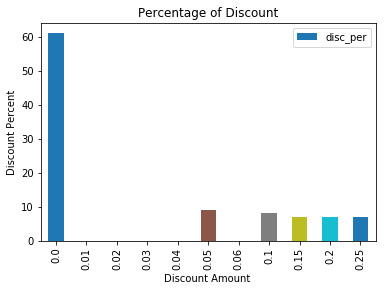

In [96]:
disc_given.plot(x='Discount_amount', y='disc_per',kind='bar')
plt.xlabel('Discount Amount ')
plt.ylabel('Discount Percent')
plt.title('Percentage of Discount')
plt.legend()
plt.show()

###### The cheapest item sold is $2 & the most expensive item is 263. the highest discount is 25% off

In [17]:
# create control and experimental groups
population = order_details['Quantity'] 
non_disc = order_details[order_details['Discount'] == 0]
non_disc = non_disc['Quantity']
disc = order_details[order_details['Discount'] != 0]
disc = disc['Quantity']


In [38]:
disc_ave=disc.mean()
print (f'The average quantity for discounted orders is {disc_ave }')

The average quantity for discounted orders is 27.10978520286396


### 2.3 Checking for assumptions: Normality, Independence & Randomness


C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


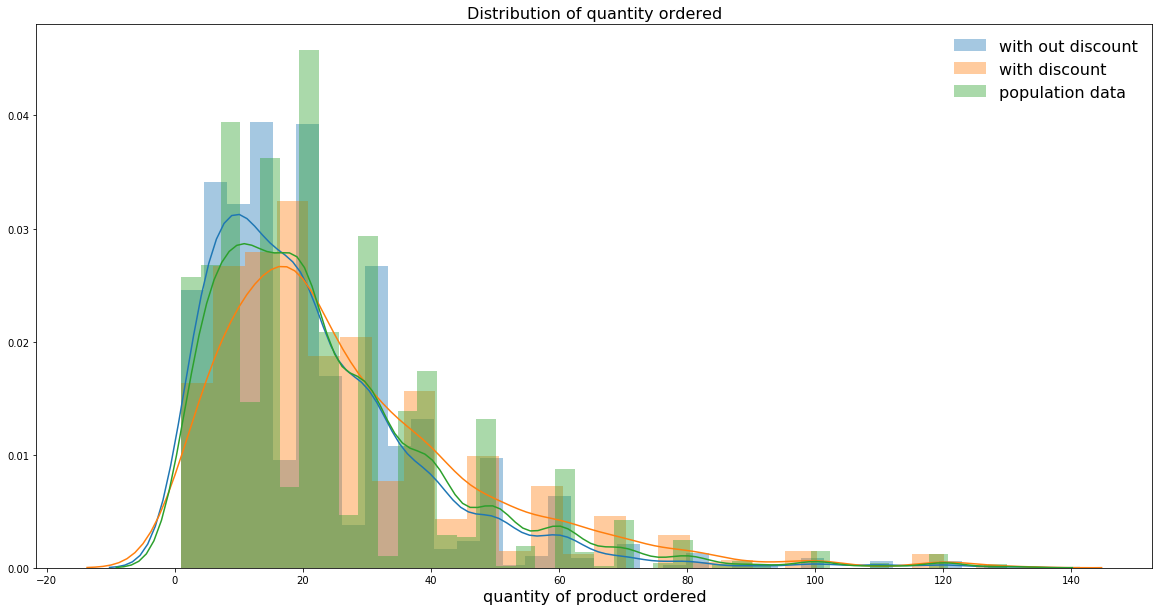

In [18]:
plt.figure(figsize=(20, 10))
sns.distplot(non_disc, label='with out discount')
sns.distplot(disc, label='with discount')
sns.distplot(population, label='population data')
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

From the plot above the all the distributions are skewed to the right and are not normal.But we can check the shapiro test to confirm that.

H0: distribution is normal
HA: distribution is not normal

In [19]:
stats.shapiro(disc) # to test if the discounted group distribution  is normal

(0.8690301179885864, 6.88120409395894e-26)

In [20]:
population.mean()

23.812993039443157

In [21]:
population.std()

19.022046977493563

In [23]:

(stats.kstest(disc, 'norm', args=(23.81, 19)))

KstestResult(statistic=0.1207327409135132, pvalue=4.2100545272205636e-11)

With a pvalue less that .05 we reject the null hypothesis and conclude that the  discounted group distribution is not normal. 

In [68]:
stats.shapiro(non_disc) # to test if the non discounted group is normal

(0.8434571027755737, 3.803856556577728e-34)

With a pvalue less that .05 we reject the null hypothesis and conclude that the   non discounted group distribution is not normal. 

In [69]:
stats.shapiro(population) # to test the population where the sample comes from is normal

(0.851548969745636, 5.022954345372307e-41)

With a pvalue less that .05 we reject the null hypothesis and conclude that the  distribution of population where the sample is coming from is not normal. 

In [98]:
len(disc)

838

In [99]:
len(non_disc)

1317

### Choosing the right test statistics

Eventhough the the distributions broke the normality assumption since we have a large sample (>30) we can proceede and do T test. 

To decide which test is appropriate we need to check the sample size & variance of the two groups. we can use the levene test.

H0: disc variance and non discount variance are the same.
HA: disc varianve and non discount variance are not the same.

In [97]:
# Testing for equal variance
stats.levene(disc, non_disc)


LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)

With low pvalue we reject the null hypothesis and conclude that the two groups have different variances. since the two groups have different sample sizes & variances Welch's t test the appropriate test.

In [62]:
# Welch's d test between discounted & non discounted group
stats.ttest_ind(non_disc, disc, equal_var=False)

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)

With low p value we reject the null hypothesis and conclude that givein discount has an effect on the quantity bought. To check how high the effect is we use the effect size by using Cohen's D test.

In [50]:
# create a function to calculate Cohen's D for any two given groups
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d


In [103]:
round(abs(Cohen_d(non_disc, disc)), 1) # taking absolute value of Cohen's d and round is to 1 decimal point

0.3

we have a Cohen's D value of  0.3 which is to the lowest side of the effect which indicates that the effect of the discount on the quantity sold is low. 

when the sample is not normal Monte Carlo test is a better choice

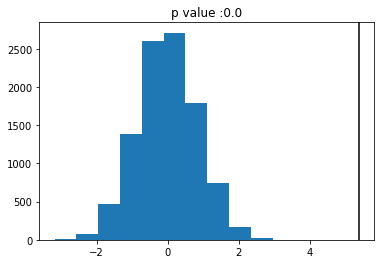

In [239]:
#mean_diff = order_details[order_details['Discount'] == 0]['Quantity'].mean()-order_details[order_details['Discount'] != 0]['Quantity'].mean()
mean_diff = disc.mean()-non_disc.mean()
sample_diffs = []
counter = 0
for i in range(10000):
    sample1 = order_details.sample(replace=False, n=len(disc))
    sample2 = order_details.drop(disc_sample.index,axis=0)
    sample_diff = disc_sample['Quantity'].mean() - non_disc_sample['Quantity'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1
plt.hist(sample_diffs)
plt.axvline(mean_diff,color = 'k')
plt.title(f'p value :{np.round(counter/10000,3)}')
plt.show()
       

#### Checking which level of discount has effect

If there is an effect, is there a significant level of difference between the discounts or all the discounts have the same effect.


 #### H0: The average quantity of product ordered is the same for each discount level.
#### Ha: The average quantity of product ordered differs across the discount levels.

In [115]:
# since we have almost very few discounts with less than .1 we combine them toghether as one value .05
disc_data = order_details[order_details['Discount'] > 0]

disc_data['Discount'] = disc_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
disc_data['Discount'].value_counts()

C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

First let's see the plot of the average quantity ordered versus the different discounts. 

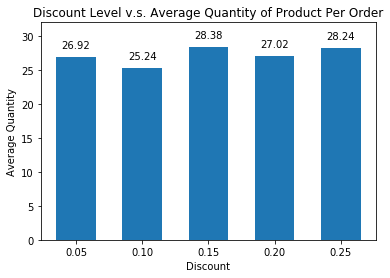

In [116]:
X = []
y = []
for i in disc_data['Discount'].unique():
    X.append(i)
    y.append(disc_data['Quantity'][disc_data['Discount'] == i].mean())
ax = plt.bar(X,y,width=.03)
plt.ylim(0,32)
plt.ylabel('Average Quantity')
plt.xlabel('Discount')
plt.title('Discount Level v.s. Average Quantity of Product Per Order')
rects = ax.patches
y_round = []
for i in y:
    y_round.append(round(i,2))
labels = y_round
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')

From the plot , we see that there is no big difference but we have to check that if this is not happnenig by chance using ANOVA test.


In [117]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,disc_data ).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),4.0,1065.701253,266.425313,0.616376,0.650947
Residual,833.0,360060.198508,432.245136,NaN,NaN


The p-value of our categorical 'Discount' variable is 0.651. Since this value is much higher than our alpha of 0.05, we fail to reject the null hypothesis. This suggests that the average quantities of product ordered across the discount levels are not significantly different.

## Conclusion

Exploring the data & running the appropriate tests we can conclude that giving a discount has a low effect on the average Quantity ordered but there is no significant difference among the different discount levels.

# Question 2. Does discount has an effect on the quantity ordered across the regions?

In [33]:

orders_region = pd.read_sql_query('''

                        SELECT  Region, OrderId, ProductId, Discount , CustomerId, Quantity FROM OrderDetail OD
                        JOIN [Order] O
                        ON OD.OrderId = O.Id
                        JOIN [Customer] C
                        ON O.CustomerId = C.Id
                        
                        ''',conn)

In [35]:
orders_region.head()

,Region,OrderId,ProductId,Discount,CustomerId,Quantity
0,Western Europe,10248,11,0.0,VINET,12
1,Western Europe,10248,42,0.0,VINET,10
2,Western Europe,10248,72,0.0,VINET,5
3,Western Europe,10249,14,0.0,TOMSP,9
4,Western Europe,10249,51,0.0,TOMSP,40


In [46]:
nondiscorder_reg=orders_region[orders_region['Discount'] == 0]
discorder_reg = orders_region[orders_region['Discount'] != 0]
#discorder_q = discorder_reg['Quantity']

In [39]:
discorder_reg.groupby('Region').mean()

,OrderId,ProductId,Discount,Quantity
Region,,,,
British Isles,10613.704918,38.393443,0.153279,31.327869
North America,10668.653179,39.786127,0.148786,30.849711
Northern Europe,10704.379310,42.482759,0.171552,25.189655
Scandinavia,10628.266667,36.400000,0.133333,18.466667
South America,10674.871795,39.239316,0.152137,19.948718
Southern Europe,10624.508475,42.644068,0.126271,17.745763
Western Europe,10644.848297,39.368421,0.136687,29.380805


In [47]:
nondiscorder_reg.groupby('Region').mean()

,OrderId,ProductId,Discount,Quantity
Region,,,,
British Isles,10650.093023,41.914729,0.0,19.496124
Central America,10584.090909,38.236364,0.0,12.109091
Eastern Europe,10789.937500,44.937500,0.0,12.812500
North America,10694.314961,40.299213,0.0,23.531496
Northern Europe,10618.188235,45.388235,0.0,22.870588
Scandinavia,10650.454545,37.545455,0.0,13.981818
South America,10666.363636,40.967914,0.0,21.524064
Southern Europe,10681.858974,41.769231,0.0,13.153846
Western Europe,10652.602906,42.694915,0.0,25.983051


In [41]:
formula = 'Quantity ~ C(Region)'
lm = ols(formula, discorder_reg).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F        PR(>F)
C(Region)   17678.580756    6.0  7.037177  2.587854e-07
Residual   334537.221974  799.0       NaN           NaN


with p value less than 0.05 we reject the null hypothesis and that means is discount has a significant effect on the quantities purchased across the different regions. which region has higher effect? 

In [120]:

d=Cohen_d(nondiscorder_reg[[nondiscorder_reg['Region'] =='Scandinavia']['Quantity'], discorder_reg[[discorder_reg['Region'] =='Scandinavia']['Quantity'])

SyntaxError: invalid syntax (<ipython-input-120-8fb3a0526d8d>, line 2)

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mod = MultiComparison(discorder_reg.Quantity, discorder_reg.Region)
print(mod.tukeyhsd())

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper  reject
----------------------------------------------------------------
 British Isles   North America  -0.4782  -9.4845   8.5282 False 
 British Isles  Northern Europe -6.1382  -17.2306  4.9541 False 
 British Isles    Scandinavia   -12.8612 -30.2923  4.5699 False 
 British Isles   South America  -11.3792 -20.9309 -1.8274  True 
 British Isles  Southern Europe -13.5821 -24.6262 -2.5381  True 
 British Isles   Western Europe -1.9471  -10.3907  6.4965 False 
 North America  Northern Europe -5.6601  -14.837   3.5169 False 
 North America    Scandinavia   -12.383  -28.6625  3.8964 False 
 North America   South America  -10.901  -18.1405 -3.6614  True 
 North America  Southern Europe -13.1039 -22.2225 -3.9854  True 
 North America   Western Europe -1.4689  -7.1672   4.2294 False 
Northern Europe   Scandinavia    -6.723  -24.2428 10.7969 False 
Northern Europe  South Am

The discount has highest effect in Britsh 

# Question 3. Do late deliveries affect Customer's ordering?

In [13]:
cur.execute("""SELECT *
              FROM [order];
              """)
orders = pd.DataFrame(cur.fetchall())
orders.columns = [i[0] for i in cur.description]
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [180]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderValue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [201]:
# orderj=pd.read_sql('''SELECT O.Id, O.CustomerId,  O.orderdate, O.requireddate, O.shippeddate,OD.UnitPrice,OD.Quantity,Od.Discount FROM [order] O JOIN OrderDetail OD ON O.Id= OD.OrderId ''',conn)
# orderj.head()
cur.execute('''SELECT O.Id, O.CustomerId,  O.orderdate, O.requireddate, O.shippeddate,O.ShipVia,OD.UnitPrice,OD.Quantity,Od.Discount FROM [order] O JOIN OrderDetail OD ON O.Id= OD.OrderId ;''')
ordersj = pd.DataFrame(cur.fetchall())
ordersj.columns = [i[0] for i in cur.description]
ordersj.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,UnitPrice,Quantity,Discount
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,14.0,12,0.0
1,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,9.8,10,0.0
2,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,34.8,5,0.0
3,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,18.6,9,0.0
4,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,42.4,40,0.0


In [202]:
ordersj['leship']= pd.to_datetime(ordersj['ShippedDate'])-pd.to_datetime(ordersj['RequiredDate']) 
ordersj.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,UnitPrice,Quantity,Discount,leship
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,14.0,12,0.0,-16 days
1,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,9.8,10,0.0,-16 days
2,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,34.8,5,0.0,-16 days
3,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,18.6,9,0.0,-37 days
4,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,42.4,40,0.0,-37 days


In [203]:
ordersj.isna().sum()

Id               0
CustomerId       0
OrderDate        0
RequiredDate     0
ShippedDate     73
ShipVia          0
UnitPrice        0
Quantity         0
Discount         0
leship          73
dtype: int64

In [249]:
ordersj.dropna(inplace=True)

In [205]:
had_late = ordersj.loc[ordersj['leship'].dt.days > 0].CustomerId.unique()
had_late

array(['FOLKO', 'SPLIR', 'BERGS', 'SUPRD', 'HUNGO', 'WARTH', 'GOURL',
       'PICCO', 'PRINI', 'QUICK', 'WHITC', 'SEVES', 'LAZYK', 'BSBEV',
       'LEHMS', 'HUNGC', 'BONAP', 'HILAA', 'EASTC', 'REGGC', 'ISLAT',
       'MORGK', 'FRANS', 'GREAL', 'RANCH', 'SAVEA', 'LACOR', 'BOLID'],
      dtype=object)

In [206]:
ordersj['HadLate']= orderj.CustomerId.isin(had_late)

In [247]:
ordersj['OrderValue']= ordersj['UnitPrice']*ordersj['Quantity']*(1-ordersj.Discount)
ordersj.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,UnitPrice,Quantity,Discount,leship,HadLate,OrderValue,ProcessingTime
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,14.0,12,0.0,-16 days,False,168.0,12
1,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,9.8,10,0.0,-16 days,False,98.0,12
2,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,34.8,5,0.0,-16 days,False,174.0,12
3,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,18.6,9,0.0,-37 days,False,167.4,5
4,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,42.4,40,0.0,-37 days,True,1696.0,5


C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


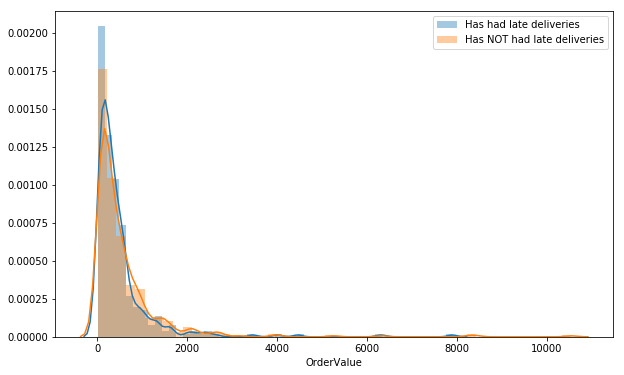

In [248]:
plt.figure(figsize=(10,6))
sns.distplot(ordersj.loc[ordersj.HadLate==True]['OrderValue'],label='Has had late deliveries')
sns.distplot(ordersj.loc[ordersj.HadLate==False]['OrderValue'], label='Has NOT had late deliveries')
plt.legend()
plt.show()

In [209]:
stats.ttest_ind(ordersj.loc[ordersj.HadLate==True]['OrderValue'],ordersj.loc[ordersj.HadLate==False]['OrderValue'],equal_var=False)


Ttest_indResult(statistic=-1.543270875266931, pvalue=0.12316437698912192)

 with high p value, we fail to reject the null hypothesis & conclude that is late deliveries has no effect on total value of order. * we have to consider looking at the customers total value after they havelate delivery *

# Question 4. Is there a statistically significant difference in performance of shipping companies?


In [210]:
ordersj.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,UnitPrice,Quantity,Discount,leship,HadLate,OrderValue
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,14.0,12,0.0,-16 days,False,168.0
1,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,9.8,10,0.0,-16 days,False,98.0
2,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,34.8,5,0.0,-16 days,False,174.0
3,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,18.6,9,0.0,-37 days,False,167.4
4,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,42.4,40,0.0,-37 days,True,1696.0


In [216]:
ordersj['ProcessingTime']= pd.to_datetime(ordersj['ShippedDate'])-pd.to_datetime(ordersj['OrderDate'])
ordersj.ProcessingTime = ordersj.ProcessingTime.dt.days
ordersj.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,UnitPrice,Quantity,Discount,leship,HadLate,OrderValue,ProcessingTime
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,14.0,12,0.0,-16 days,False,168.0,12
1,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,9.8,10,0.0,-16 days,False,98.0,12
2,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,34.8,5,0.0,-16 days,False,174.0,12
3,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,18.6,9,0.0,-37 days,False,167.4,5
4,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,42.4,40,0.0,-37 days,True,1696.0,5


In [219]:
ordersj.groupby('ShipVia').mean()

,Id,UnitPrice,Quantity,Discount,OrderValue,ProcessingTime
ShipVia,,,,,,
1,10656.803459,24.599041,24.732704,0.060613,544.388432,8.316038
2,10657.479064,28.201330,23.639163,0.055049,636.182264,8.993842
3,10617.776025,25.832256,23.965300,0.053076,594.707521,7.544164


In [217]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, ordersj).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(ShipVia)    748.990774     2.0  8.419976  0.000228
Residual    92467.709034  2079.0       NaN       NaN


In [218]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mod = MultiComparison(ordersj.ProcessingTime, ordersj.ShipVia)
print(mod.tukeyhsd())


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.6778  -0.1505  1.5061 False 
  1      3    -0.7719  -1.6497  0.106  False 
  2      3    -1.4497  -2.2787 -0.6207  True 
---------------------------------------------


In [ ]:
shipping company 3 has significantly law procesing time

In [198]:
#products.head()
# discount vs reorder

In [7]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [10]:
suppliers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


In [25]:
suppliers.Region.unique()

array(['British Isles', 'North America', 'Eastern Asia',
       'Southern Europe', 'Victoria', 'Northern Europe', 'South America',
       'Western Europe', 'Scandinavia', 'South-East Asia', 'NSW'],
      dtype=object)

In [9]:
products.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [65]:
discproduct=products.groupby(products['CategoryId']).agg({'Discontinued':'count'}).reset_index()#.rename(columns= {'Id':'Discounts','Discount':'Discount_amount'})

In [66]:
discproduct

,CategoryId,Discontinued
0,1,12
1,2,12
2,3,13
3,4,10
4,5,7
5,6,6
6,7,5
7,8,12


In [21]:
products.SupplierId.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

In [23]:
products.CategoryId.unique()

array([1, 2, 7, 6, 8, 4, 3, 5], dtype=int64)

In [27]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [15]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [ ]:
cur.execute('''SELECT O.Id, O.CustomerId,  O.orderdate, O.requireddate, O.shippeddate,O.ShipVia,OD.UnitPrice,OD.Quantity,Od.Discount FROM [order] O JOIN OrderDetail OD ON O.Id= OD.OrderId ;''')
ordersj = pd.DataFrame(cur.fetchall())
ordersj.columns = [i[0] for i in cur.description]
ordersj.head()

In [18]:
territories.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [74]:
pd.options.display.max_colwidth = 400
print(employees.Notes)


0                                                                                                                                                                                                                                    Education includes a BA in psychology from Colorado State University in 1970.  She also completed 'The Art of the Cold Call.'  Nancy is a member of Toastmasters International.
1    Andrew received his BTS commercial in 1974 and a Ph.D. in international marketing from the University of Dallas in 1981.  He is fluent in French and Italian and reads German.  He joined the company as a sales representative, was promoted to sales manager in January 1992 and to vice president of sales in March 1993.  Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of ...
2                                                                                                                                                                    Janet has a BS degree in 

In [121]:
emp_invoices = pd.read_sql('''SELECT  o.EmployeeId,od.UnitPrice ,od.Discount,od.Quantity
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                           
                    
                    ''', conn)
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity
0,5,14.0,0.0,12
1,5,9.8,0.0,10
2,5,34.8,0.0,5
3,6,18.6,0.0,9
4,6,42.4,0.0,40


In [123]:
emp_invoices['totalinv']= emp_invoices.UnitPrice * (1 - emp_invoices.Discount) * emp_invoices.Quantity

In [124]:
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity,totalinv
0,5,14.0,0.0,12,168.0
1,5,9.8,0.0,10,98.0
2,5,34.8,0.0,5,174.0
3,6,18.6,0.0,9,167.4
4,6,42.4,0.0,40,1696.0


In [129]:
emp_invoices['trained']= 1

In [132]:
nottrained=[1,4,8,9]
for x in nottrained: 
    emp_invoices.loc[emp_invoices.EmployeeId==x,['trained']]=0

In [135]:
 emp_invoices['bilingual']=0

In [136]:
bi=[2,6,8,9]
for x in bi: 
    emp_invoices.loc[emp_invoices.EmployeeId==x,['bilingual']]=1

In [137]:
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity,totalinv,trained,bilingual
0,5,14.0,0.0,12,168.0,1,0
1,5,9.8,0.0,10,98.0,1,0
2,5,34.8,0.0,5,174.0,1,0
3,6,18.6,0.0,9,167.4,1,1
4,6,42.4,0.0,40,1696.0,1,1


In [99]:
total_sale_e = pd.read_sql('''SELECT OD.OrderId,O.EmployeeId
                            FROM OrderDetail OD
                            JOIN [Order] O ON OD.OrderId = O.Id
                            JOIN Employee E ON O.EmployeeId = E.Id ''', conn)

In [100]:
employees_orders = pd.read_sql( '''
                                    
                                SELECT O.EmployeeId, E.Country, COUNT(O.Id) AS Total_Orders  
                                FROM [Order] AS O
                                JOIN Employee as E
                                ON O.EmployeeId = E.Id
                                GROUP BY O.EmployeeId
                                
                                ''' ,conn)
employees_orders

,EmployeeId,Country,Total_Orders
0,1,USA,123
1,2,USA,96
2,3,USA,127
3,4,USA,156
4,5,UK,42
5,6,UK,67
6,7,UK,72
7,8,USA,104
8,9,UK,43


In [90]:
employees

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath,trained
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Colorado State University in 1970. She also completed 'The Art of the Cold Call.' Nancy is a member of Toastmasters International.,2.0,http://accweb/emmployees/davolio.bmp,0
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,"Andrew received his BTS commercial in 1974 and a Ph.D. in international marketing from the University of Dallas in 1981. He is fluent in French and Italian and reads German. He joined the company as a sales representative, was promoted to sales manager in January 1992 and to vice president of sales in March 1993. Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of ...",NaN,http://accweb/emmployees/fuller.bmp,1
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston College (1984). She has also completed a certificate program in food retailing management. Janet was hired as a sales associate in 1991 and promoted to sales representative in February 1992.,2.0,http://accweb/emmployees/leverling.bmp,1
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from Concordia College (1958) and an MA from the American Institute of Culinary Arts (1966). She was assigned to the London office temporarily from July through November 1992.,2.0,http://accweb/emmployees/peacock.bmp,0
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,"Steven Buchanan graduated from St. Andrews University, Scotland, with a BSC degree in 1976. Upon joining the company as a sales representative in 1992, he spent 6 months in an orientation program at the Seattle office and then returned to his permanent post in London. He was promoted to sales manager in March 1993. Mr. Buchanan has completed the courses 'Successful Telemarketing' and 'Inter...",2.0,http://accweb/emmployees/buchanan.bmp,1
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,"Michael is a graduate of Sussex University (MA, economics, 1983) and the University of California at Los Angeles (MBA, marketing, 1986). He has also taken the courses 'Multi-Cultural Selling' and 'Time Management for the Sales Professional.' He is fluent in Japanese and can read and write French, Portuguese, and Spanish.",5.0,http://accweb/emmployees/davolio.bmp,1
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,"Robert King served in the Peace Corps and traveled extensively before completing his degree in English at the University of Michigan in 1992, the year he joined the company. After completing a course entitled 'Selling in Europe,' he was transferred to the London office in March 1993.",5.0,http://accweb/emmployees/davolio.bmp,0
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the University of Washington. She has also completed a course in business French. She reads and writes French.,2.0,http://accweb/emmployees/davolio.bmp,0
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne

In [19]:
emp_territories.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [36]:
# cur.execute('''select * from [order] O inner join OrderDetail OD  on
# O.Id = OD.OrderId join product P  on 
# p.Id = OD.OrderId;''')
# order_p_detail = pd.DataFrame(cur.fetchall())
# order_p_detail.columns = [i[0] for i in cur.description]
# order_p_detail.head()

In [ ]:
('''select * from orders O inner join OrderDetail OD  on
o.Id = OD.OrderId join products P  on 
p.Id = OD.OrderId;''')